In [1]:
import numpy as np
from scipy.optimize import fsolve

import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp

import rubin_sim.maf as maf
import rubin_sim.utils as rsUtils
from rubin_sim.data import get_baseline, get_data_dir
import os
from rubin_sim.photUtils import Bandpass, PhotometricParameters

In [2]:
# Can compute instrumental zeropoints with Bandpass object


The number of photons detected in a single pixel from an object of constant surface brightness $\mu$:

\begin{equation}
N_{photons, source} = 10^{\frac{\mu_{source} - Z_p + kX}{-2.5}} * A_{pix} * t_{exp}
\end{equation}

where $Z_p$ is the telescope instrumental zeropoint, $k$ is the atmospheric extinction term, $X$ is airmass, $A_{pix}$ is the area of a pixel (e.g., pixscale squared),, and $t_{exp}$ is the exposure time.

The number of photons from the sky background will then be (note we drop the airmass extinction):
\begin{equation}
N_{photons, sky} = 10^{\frac{\mu_{sky} - Z_p}{-2.5}} * A_{pix} * t_{exp}
\end{equation}

So the total SNR for a single pixel should be:

\begin{equation}
\frac{S}{N} = \frac{N_{photons, source}}{\sqrt{N_{photons, source} + N_{photons, sky} + RN^2}}
\end{equation}

where RN is the readnoise in electrons. 

Let's have a look at the different limiting casses

## Source limited
In the source-limit, for a single pixel:
\begin{equation}
SNR/pix = \sqrt{N_{photons,source}}
\end{equation}
and then the final total SNR will be
\begin{equation}
SNR = \sqrt{N_{pix}}\sqrt{N_{photons,source}}
\end{equation}
If I work this out on paper I end up with
\begin{equation}
\mu_{source} = -1.25\log_{10}{SNR} + \frac{1.25}{2}\log_{10}{N_{pix}A_{pix}t_{exp}} + Z_p -kX
\end{equation}


## Background limited

\begin{equation}
SNR/pix = \frac{N_{photons,source}}{\sqrt{N_{photons, sky}}}
\end{equation}
then the total SNR
\begin{equation}
SNR = \sqrt{N_{pix}} \frac{N_{photons,source}}{\sqrt{N_{photons, sky}}}
\end{equation}

\begin{equation}
N_{photons,source}^2 = \frac{SNR^2 N_{photons, sky}}{N_{pix}}
\end{equation}

\begin{equation}
A_{pix}^2 t_{exp}^2 10^{\frac{\mu_{source} - Z_p + kX}{-1.25}} = \frac{SNR^2A_{pix}t_{exp}10^{\frac{\mu_{sky} - Z_p}{-2.5}}}{N_{pix}}
\end{equation}

\begin{equation}
10^{\frac{\mu_{source} - Z_p + kX}{-1.25}} = \frac{SNR^2 10^{\frac{\mu_{sky} - Z_p}{-2.5}}}{ A_{pix} t_{exp} N_{pix}}
\end{equation}

\begin{equation}
\mu_{source} - Z_p + kX =-1.25 \log_{10}{\frac{SNR^2}{ A_{pix} t_{exp} N_{pix}}} + 0.5(\mu_{sky} -Z_p)
\end{equation}

\begin{equation}
\mu_{source} =-1.25 \log_{10}{\frac{SNR^2}{A_{pix} t_{exp} N_{pix}}} + 0.5\mu_{sky} +0.5Z_p - kX
\end{equation}





## Readnoise limited

\begin{equation}
SNR/pix = \frac{N_{photons,source}}{RN}
\end{equation}

\begin{equation}
\frac{SNR RN}{\sqrt{N_{pix}}}  = 10^{\frac{\mu_{source} - Z_p + kX}{-2.5}} * A_{pix} * t_{exp}
\end{equation}

\begin{equation}
\mu_{source} = -2.5\log_{10} \frac{SNR RN}{A_{pix} t_{exp} \sqrt{N_{pix}}} + Z_p -kX
\end{equation}

# Combining limiting magnitudes
A quick justification for how to combine limiting magnitudes

We define $m_N$ as the magnitude where the SNR = N (Usually 5, but whatever)

so:
\begin{equation}
\frac{flux_N}{Noise} = N
\end{equation}

Let's look at a flux ratio with some arbitrary mag $m$
\begin{equation}
m-m_N = -2.5 \log_{10}{\frac{flux}{flux_N}} 
\end{equation}

SNR at that new magnitude is
\begin{equation}
\frac{flux}{Noise} = SNR
\end{equation}

substitute in
\begin{equation}
m-m_N = -2.5 \log_{10}{\frac{SNR * Noise}{N*Noise}} 
\end{equation}

solve for the SNR of an arbitrary mag $m$ given $m_N$:
\begin{equation}
SNR = N 10^{-0.4(m-m_N)}
\end{equation}




Now, if we have a bunch of limiting magnitudes $m_{5,i}$, what is the final SNR if we coadd them? The SNR for some fiducial mag $m$ in each frame will be
\begin{equation}
SNR_i = N 10^{-0.4(m-m_{N,i})}
\end{equation}

SNR adds in quadrature
\begin{equation}
SNR_{coadd} = \sqrt{\sum_i SNR_i^2}
\end{equation}


\begin{equation}
SNR_{coadd} = \sqrt{\sum_i N^2 10^{-0.8(m-m_{N,i})}}
\end{equation}




from above we know:
\begin{equation}
m-m_{N,coadd} = -2.5\log_{10} \frac{SNR_{coadd}}{N}
\end{equation}

subsitute in $SNR_{coadd}$ from above:
\begin{equation}
-m_{N,coadd} = -2.5\log_{10} \frac{\sqrt{\sum_i N^2 10^{-0.8(m-m_{N,i})}}}{N} - m
\end{equation}

\begin{equation}
m_{N,coadd} = 2.5\log_{10} \sqrt{\sum_i 10^{-0.8(m-m_{N,i})}} + m
\end{equation}

We've just been carrying $m$ around as an arbitray magnitude, so I think we can set $m=0$ and simplify to
\begin{equation}
m_{N,coadd} = 1.25\log_{10} \sum_i 10^{0.8m_{N,i}}
\end{equation}
So there we go, if we have lots of images with unique N-sigma depth values, we can compute what the N-sigma depth would be if they were coadded

In [3]:
def numphot(mu, zp, k, airmass, area_pix=0.2**2, t_exp=30.):
    result = 10.**((mu-zp+k*airmass)/(-2.5)) * area_pix * t_exp
    return result

In [4]:
numphot(22, 22, 0.126, np.array([1.0, 1.1, 1.2, 1.5]))

array([1.06851653, 1.05618804, 1.0440018 , 1.00828022])

In [5]:
def surface_brightness_limit_approx(zp, k, airmass, mu_sky, rn=8.8, pixscale=0.2,
                             nsigma=3., t_exp=30., tot_area=100.):
    """Like surface_brightness_limit, but let's just analytically solve for 
    the limiting cases since that should be much faster
    
    Parameters
    ---------
    zp : float
        Telescope zeropoint (mags)
    k : float
        Atmospheric extinction term
    airmass : float
        Airmass
    mu_sky : float
        Surface brightness of the sky (mag/sq arcsec)
    rm : float (8.8)
        Readnoise in electrons
    pixscale : float (0.2)
        Arcseconds per pixel
    nsigma : float (3)
        The SNR to demand
    t_exp : float (30.)
        Exposure time (seconds)
    tot_area : float (100)
        The total area measuring over (sq arcsec)
        
    Returns
    -------
    surface brightness limit in mags/sq arcsec
    aka the surface brightness that reaches SNR=nsigma when measured over tot_area.
    """
    
    n_pix = tot_area/pixscale
    
    
    A_pix = pixscale**2
    
    
    # Sky limited case
    mu_sky_lim = -1.25*np.log10(nsigma**2/(A_pix*t_exp*n_pix)) + 0.5*mu_sky + 0.5*zp -k*airmass
    
    # Source limited case
    # XXX--double check this algerbra. Pretty sure it's right now.
    mu_source_lim = -1.25*np.log10(nsigma) +1.25/2.*np.log10(n_pix*A_pix*t_exp) +zp - k*airmass
    
    # Readnoise limited case
    mu_rn_lim = -2.5*np.log10(nsigma*rn/(t_exp*A_pix*n_pix**0.5)) + zp - k*airmass
    
    result = np.vstack([mu_sky_lim, mu_source_lim, mu_rn_lim])
    result = np.min(result, axis=0)
    
    return result

\begin{equation}
\mu_{source} = -2.5\log_{10} \frac{SNR RN}{A_{pix} t_{exp} \sqrt{N_{pix}}} + Z_p -kX
\end{equation}

\begin{equation}
\mu_{source} =-1.25 \log_{10}{\frac{SNR^2}{A_{pix} t_{exp} N_{pix}}} + 0.5\mu_{sky} +0.5Z_p - kX
\end{equation}


In [6]:
zp=28.
k=0
airmass = 1.0
mu_sky=20
t_exp=30

surface_brightness_limit_approx(zp, k, airmass, mu_sky, rn=8.8, pixscale=0.2,
                             nsigma=3., t_exp=t_exp, tot_area=100.)

array([26.27988593])

In [7]:
zp=28.
k=0
airmass = 1.0
mu_sky=35
t_exp=30

surface_brightness_limit_approx(zp, k, airmass, mu_sky, rn=8.8, pixscale=0.2,
                             nsigma=3., t_exp=t_exp, tot_area=100.)

array([28.0176558])

In [8]:
class SurfaceBrightLimitMetric(maf.BaseMetric):
    """Gaussian limit, ignoring systematic errors in photometry
    """
    def __init__(self, pixscale=0.2, nsigma=3., t_exp=30., tot_area=100.,
                 filterCol='filter', units='mag/sq arcsec', airmassCol='airmass',
                 exptimeCol='visitExposureTime', metricName='SurfaceBrightLimit', 
                 skybrightnessCol='skyBrightness', nexpCol='numExposures', zpt=None, kAtm=None,
                 readnoise=8.8,
                 **kwargs):
        super().__init__(col=[filterCol, airmassCol,
                              exptimeCol, skybrightnessCol, nexpCol],
                         units=units, metricName=metricName, **kwargs)
        self.filterCol = filterCol
        self.airmassCol = airmassCol
        self.exptimeCol = exptimeCol
        self.skybrightnessCol = skybrightnessCol
        self.nexpCol = nexpCol
        
        self.readnoise = readnoise
        self.pixscale = pixscale
        self.nsigma = nsigma
        self.tot_area = tot_area
        
        # Compute default zeropoints
        if zpt is None:
            zp_inst = {}
            datadir = get_data_dir()
            for filtername in 'ugrizy':
                # set gain and exptime to 1 so the instrumental zeropoint will be in photoelectrons and per second
                phot_params = PhotometricParameters(nexp=1, gain=1, exptime=1, bandpass=filtername)
                bp = Bandpass()
                bp.readThroughput(os.path.join(datadir, 'throughputs/baseline/','total_%s.dat' % filtername))
                zp_inst[filtername] = bp.calcZP_t(phot_params)
            self.zpt = zp_inst
        else:
            self.zpt = zpt
        if kAtm is None:
            syseng = rsUtils.SysEngVals()
            self.kAtm = syseng.kAtm
        else:
            self.kAtm = kAtm
    
    def run(self, dataSlice, slicePoint):
        filtername = np.unique(dataSlice[self.filterCol])
        if np.size(filtername) > 1:
            ValueError('Can only coadd depth in single filter, got filters %s' % filtername)
        filtername = filtername[0]
        
        # Scale up readnoise if the visit was split into multiple snaps
        readnoise = self.readnoise * np.sqrt(dataSlice[self.nexpCol])
        
        # Use the sky-limited approximation
        sb_per_visit =  surface_brightness_limit_approx(self.zpt[filtername], self.kAtm[filtername],
                                             dataSlice[self.airmassCol], dataSlice[self.skybrightnessCol],
                                             rn=readnoise, pixscale=self.pixscale,
                                             nsigma=self.nsigma, t_exp=dataSlice[self.exptimeCol],
                                             tot_area=self.tot_area)

        coadd_sb_limit = 1.25 * np.log10(np.sum(10**(0.8 * sb_per_visit)))
        return coadd_sb_limit
        

In [9]:
baseline_file = get_baseline()
name = os.path.basename(baseline_file).replace('.db','')
conn = maf.db.OpsimDatabase(baseline_file)
outDir = 'temp'
resultsDb = maf.db.ResultsDb(outDir=outDir)


Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter="y" for columns ['filter', 'rotSkyPos', 'fieldRA', 'fieldDec', 'skyBrightness', 'airmass', 'numExposures', 'visitExposureTime']
Found 404071 visits
Running:  ['baseline_nexp2_v1_7_10yrs_SurfaceBrightLimit_y_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter="z" for columns ['filter', 'rotSkyPos', 'fieldRA', 'fieldDec', 'skyBrightness', 'airmass', 'numExposures', 'visitExposureTime']
Found 397742 visits
Running:  ['baseline_nexp2_v1_7_10yrs_SurfaceBrightLimit_z_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter="r" for columns ['filter', 'rotSkyPos', 'fieldRA', 'fieldDec', 'skyBrightness', 'airmass', 'numExposures', 'visitExposureTime']
Found 452001 

0.0 180.0 -180.0 180.0


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "filter="y"" constraint now.


/Users/yoachim/git_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:117: UserWarning: Optimal bin calculation tried to make 258 bins, returning 200
  warnings.warn(
0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "filter="z"" constraint now.


0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "filter="r"" constraint now.


0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "filter="u"" constraint now.


0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "filter="i"" constraint now.


0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "filter="g"" constraint now.
Plotting complete.


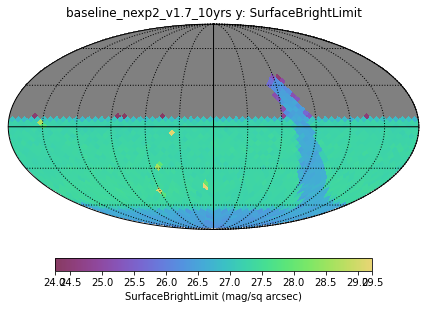

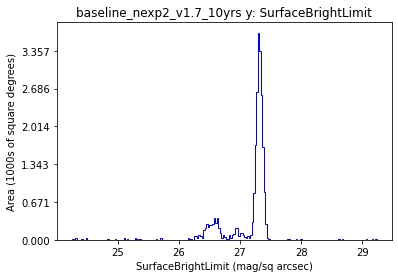

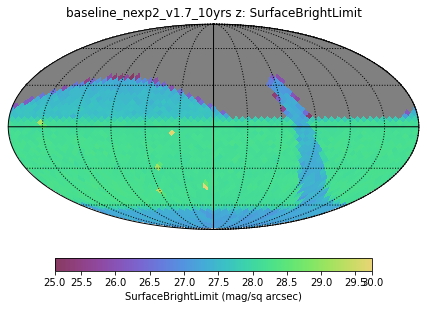

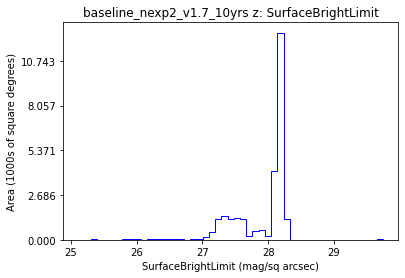

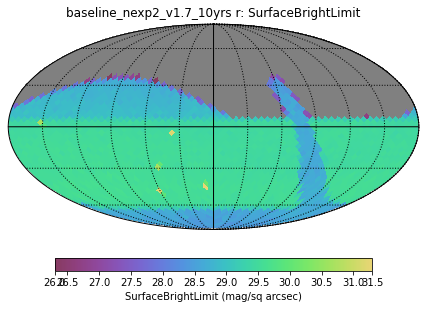

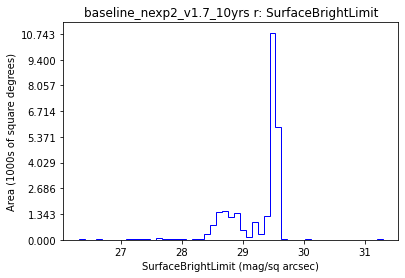

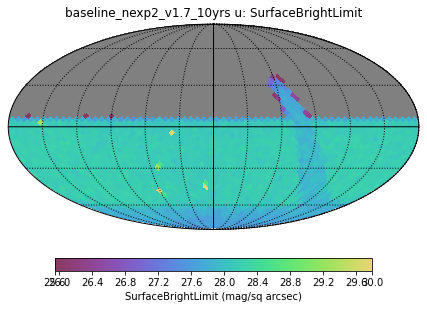

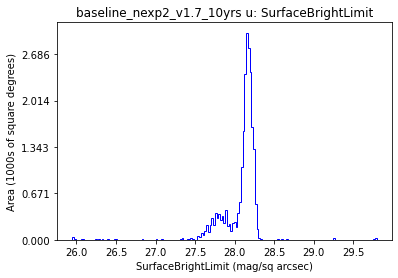

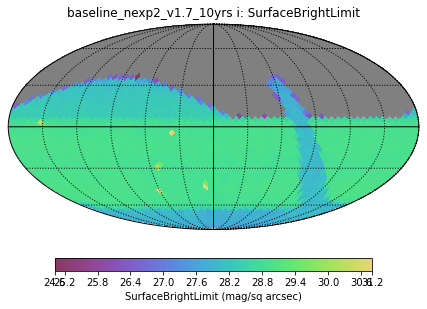

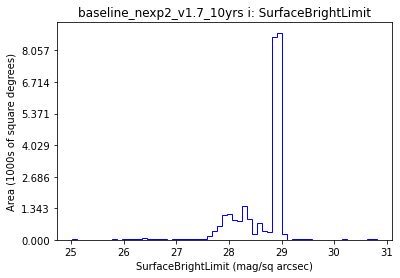

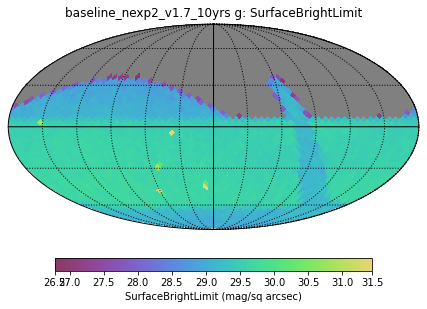

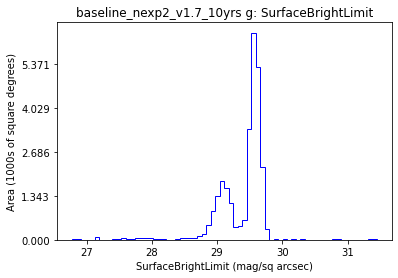

In [10]:
bundleList = []
slicer = maf.slicers.HealpixSlicer(nside=16)

summary_stats = [maf.metrics.MedianMetric()]

for filtername in 'ugrizy':
    metric = SurfaceBrightLimitMetric()
    # Select all the visits
    sql = 'filter="%s"' % filtername
    #bundleList.append(maf.MetricBundle(metric, slicer, sql, runName=name, summaryMetrics=summary_stats))
    
    metric = SurfaceBrightLimitMetric()
    bundleList.append(maf.MetricBundle(metric, slicer, sql, runName=name, summaryMetrics=summary_stats))
bd = maf.metricBundles.makeBundlesDictFromList(bundleList)
bg = maf.metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()
bg.plotAll(closefigs=False)

In [11]:
for b in bundleList:
    print(b.constraint, b.summaryValues)

filter="u" {'Median': 28.14708262851205}
filter="g" {'Median': 29.531197844102643}
filter="r" {'Median': 29.474368253461552}
filter="i" {'Median': 28.877250359661467}
filter="z" {'Median': 28.141095892891514}
filter="y" {'Median': 27.29762043826055}


Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter="z" and night < 730 for columns ['filter', 'rotSkyPos', 'fieldRA', 'fieldDec', 'skyBrightness', 'airmass', 'numExposures', 'visitExposureTime']
Found 75226 visits
Running:  ['baseline_nexp2_v1_7_10yrs_SurfaceBrightLimit_approx_z_and_night_lt_730_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter="y" and night < 730 for columns ['filter', 'rotSkyPos', 'fieldRA', 'fieldDec', 'skyBrightness', 'airmass', 'numExposures', 'visitExposureTime']
Found 90489 visits
Running:  ['baseline_nexp2_v1_7_10yrs_SurfaceBrightLimit_approx_y_and_night_lt_730_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter="r" and night < 730 for columns ['filter', 'rotSkyPos', 'fieldR

0.0 180.0 -180.0 180.0


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "filter="z" and night < 730" constraint now.


0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "filter="y" and night < 730" constraint now.


0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "filter="r" and night < 730" constraint now.


0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "filter="u" and night < 730" constraint now.


0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "filter="g" and night < 730" constraint now.


0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "filter="i" and night < 730" constraint now.
Plotting complete.


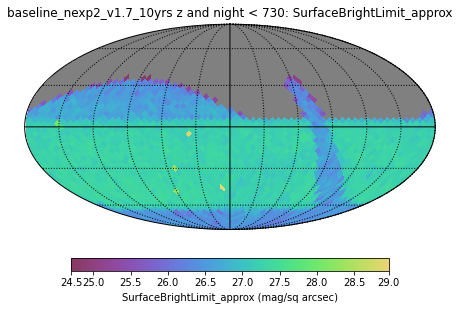

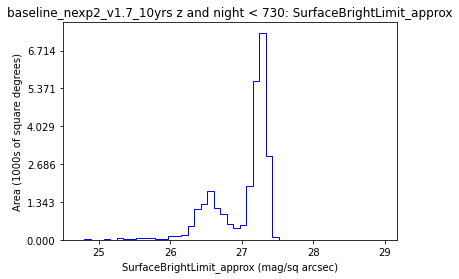

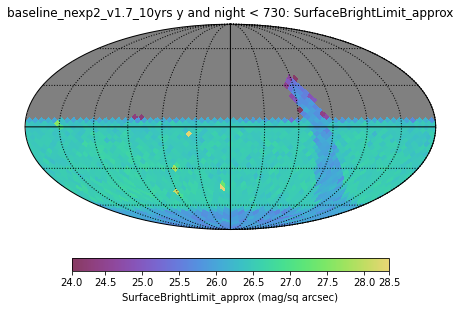

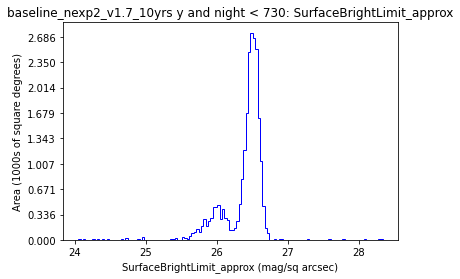

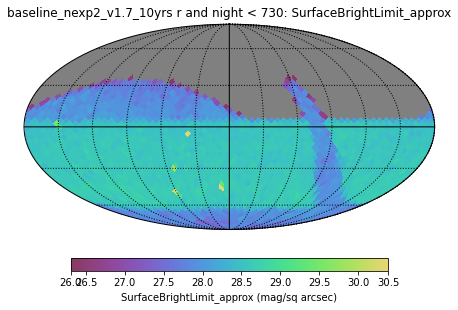

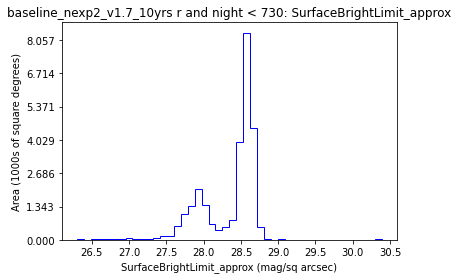

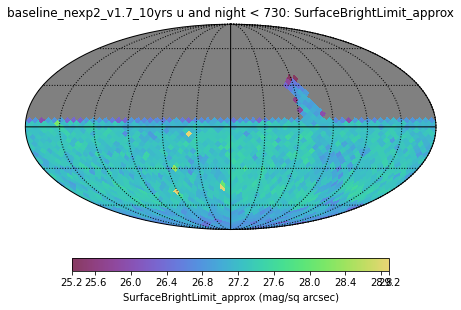

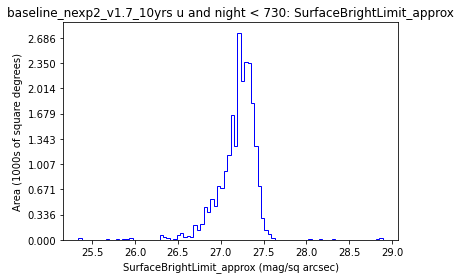

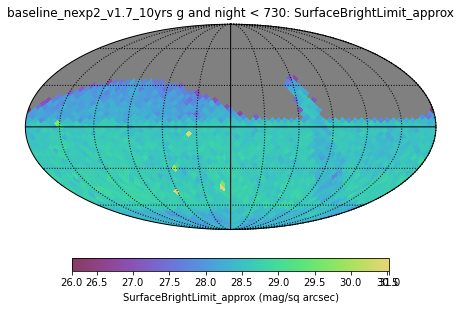

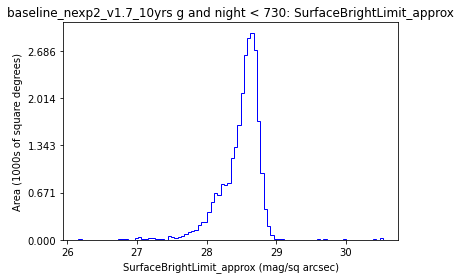

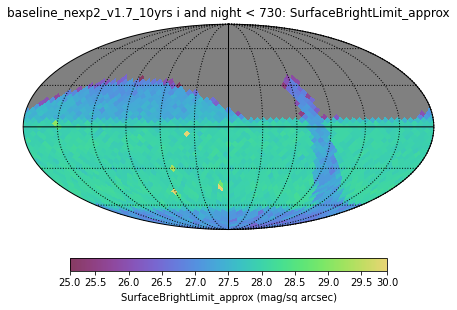

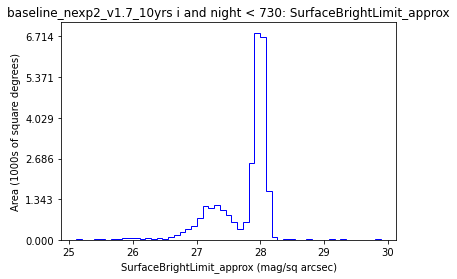

In [12]:
# Let's do it for the first two years and see if that scales reasonably
bundleList = []
slicer = maf.slicers.HealpixSlicer(nside=16)

summary_stats = [maf.metrics.MedianMetric()]

for filtername in 'ugrizy':
    metric = SurfaceBrightLimitMetric()
    # Select all the visits
    sql = 'filter="%s" and night < 730' % filtername
    #bundleList.append(maf.MetricBundle(metric, slicer, sql, runName=name, summaryMetrics=summary_stats))
    
    metric = SurfaceBrightLimitMetric( metricName='SurfaceBrightLimit_approx')
    bundleList.append(maf.MetricBundle(metric, slicer, sql, runName=name, summaryMetrics=summary_stats))
bd = maf.metricBundles.makeBundlesDictFromList(bundleList)
bg = maf.metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()
bg.plotAll(closefigs=False)

In [13]:
for b in bundleList:
    print(b.constraint, b.summaryValues)

filter="u" and night < 730 {'Median': 27.225430978199014}
filter="g" and night < 730 {'Median': 28.556735551964824}
filter="r" and night < 730 {'Median': 28.528509140733526}
filter="i" and night < 730 {'Median': 27.935614836267682}
filter="z" and night < 730 {'Median': 27.201214285771563}
filter="y" and night < 730 {'Median': 26.46924467449395}


In [14]:
# looks like we are actually readnoise limited? Let's look at some numbers to double check things

# load up the zeropoints
zp_inst = {}
datadir = get_data_dir()
for filtername in 'ugrizy':
    # set gain and exptime to 1 so the instrumental zeropoint will be in photoelectrons and per second
    phot_params = PhotometricParameters(nexp=1, gain=1, exptime=1, bandpass=filtername)
    bp = Bandpass()
    bp.readThroughput(os.path.join(datadir, 'throughputs/baseline/','total_%s.dat' % filtername))
    zp_inst[filtername] = bp.calcZP_t(phot_params)

In [15]:
zp_inst['r'] # so, something of this magnitude will generate 1 e-/s 

28.131005103939575

In [16]:
# That means, if we have mu=25, we should expect this many e-/s/pixel (ignoring airmass extinction)
10.**((25-zp_inst['r'])/-2.5) * 0.2**2

0.7152568618206481

In [17]:
# or this many in a 30s exposure in a pixel
10.**((25-zp_inst['r'])/-2.5) * 0.2**2*30

21.45770585461944

In [18]:
# meanwhile, the sky is around mu_r = 21, so it will make this many e- in a pixel
10.**((21-zp_inst['r'])/-2.5) * 0.2**2*30

854.2466564351756

In [19]:
854**0.5


29.223278392404914

In [20]:
8.8*2**0.5

12.445079348883239

In [21]:
# So, this looks to me like we have sigma_sky = 29, sigma_readnoise = 12.4 (in a two snap visit), and sigma_source = 4
# That really seems like it should be sky-limited. 

In [22]:
surface_brightness_limit_approx(28, 0, 1, 21, rn=8.8, pixscale=0.2,
                             nsigma=3., t_exp=30., tot_area=100.)

array([26.77988593])

In [23]:
surface_brightness_limit_approx(28, 0, 1, 21, rn=0, pixscale=0.2,
                             nsigma=3., t_exp=30., tot_area=100.)

/var/folders/05/z_zc9f654c5dlw06t4s_d68w0000gn/T/ipykernel_19510/3385182667.py:47: RuntimeWarning: divide by zero encountered in log10
  mu_rn_lim = -2.5*np.log10(nsigma*rn/(t_exp*A_pix*n_pix**0.5)) + zp - k*airmass


array([26.77988593])

In [24]:
surface_brightness_limit_approx(28, 0, 1, 21, rn=100, pixscale=0.2,
                             nsigma=3., t_exp=30., tot_area=100.)

array([25.37886248])

In [25]:
# OK, now that looks good. In the r-band, we are sky-limited. In the u we are probably still a little readnoise doiminated
# 

Querying database SummaryAllProps with constraint filter="y" for columns ['filter', 'rotSkyPos', 'fieldRA', 'fieldDec', 'skyBrightness', 'airmass', 'numExposures', 'visitExposureTime']
Found 404071 visits
Running:  ['baseline_nexp2_v1_7_10yrs_SurfaceBrightLimit_y_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter="z" for columns ['filter', 'rotSkyPos', 'fieldRA', 'fieldDec', 'skyBrightness', 'airmass', 'numExposures', 'visitExposureTime']
Found 397742 visits
Running:  ['baseline_nexp2_v1_7_10yrs_SurfaceBrightLimit_z_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter="r" for columns ['filter', 'rotSkyPos', 'fieldRA', 'fieldDec', 'skyBrightness', 'airmass', 'numExposures', 'visitExposureTime']
Found 452001 visits
Running:  ['baseline_nexp2_v1_7_10yrs_SurfaceBrightLimit_r_USER']
Com

0.0 180.0 -180.0 180.0


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "filter="y"" constraint now.


0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "filter="z"" constraint now.


0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "filter="r"" constraint now.


0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "filter="u"" constraint now.


0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "filter="i"" constraint now.


0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "filter="g"" constraint now.
Plotting complete.


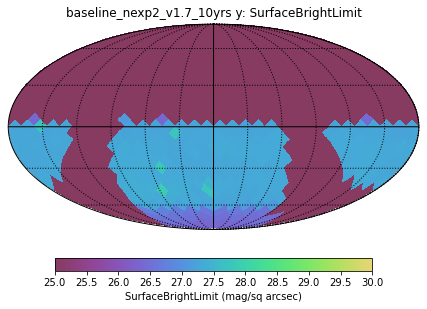

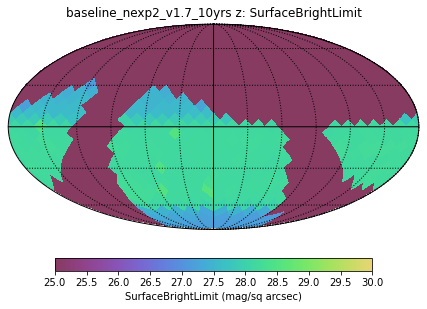

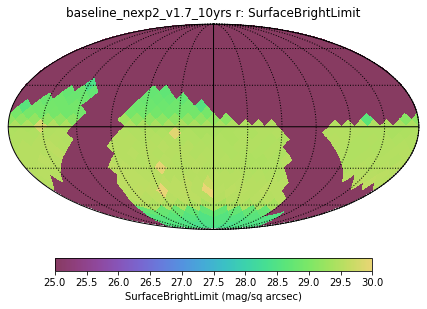

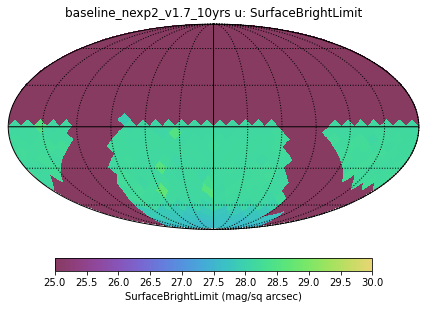

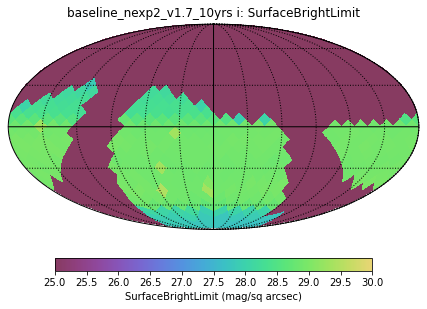

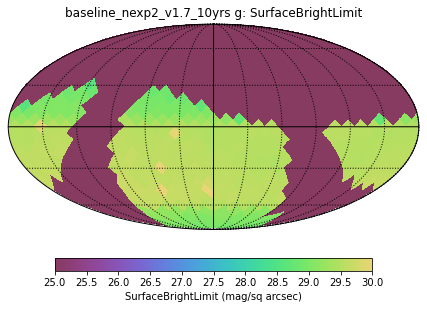

In [26]:
# Let's exclude the galactic plane
from rubin_sim.utils import hpid2RaDec, galacticFromEquatorial
from rubin_sim.maf.plots import HealpixSkyMap

nside = 16
ra, dec = hpid2RaDec(nside, np.arange(hp.nside2npix(nside)))
gall, galb = galacticFromEquatorial(ra, dec)

lat_limit = 20.

good_pix = np.where(np.abs(galb) > lat_limit)[0]


bundleList = []
slicer = maf.slicers.UserPointsSlicer(ra[good_pix], dec[good_pix])
slicer.slicePoints['nside'] = nside

summary_stats = [maf.metrics.MedianMetric()]
plotfuncs = [HealpixSkyMap()]
plotDict={'colorMin': 25, 'colorMax': 30}

for filtername in 'ugrizy':
    metric = SurfaceBrightLimitMetric()
    # Select all the visits
    sql = 'filter="%s"' % filtername
    #bundleList.append(maf.MetricBundle(metric, slicer, sql, runName=name, summaryMetrics=summary_stats))
    
    metric = SurfaceBrightLimitMetric()
    bundleList.append(maf.MetricBundle(metric, slicer, sql, runName=name, summaryMetrics=summary_stats,
                                      plotFuncs=plotfuncs, plotDict=plotDict))
bd = maf.metricBundles.makeBundlesDictFromList(bundleList)
bg = maf.metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()
bg.plotAll(closefigs=False)

In [27]:
for b in bundleList:
    print(b.constraint, b.summaryValues)

filter="u" {'Median': 28.152853510362323}
filter="g" {'Median': 29.534808689652756}
filter="r" {'Median': 29.48036992907898}
filter="i" {'Median': 28.88096746933792}
filter="z" {'Median': 28.146405171468096}
filter="y" {'Median': 27.299678804764554}
